**Chapter 16 – Reinforcement Learning**

This notebook contains all the sample code and solutions to the exercices in chapter 16.

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [42]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import numpy.random as rnd
import os

# to make this notebook's output stable across runs
rnd.seed(42)

# To plot pretty figures and animations
%matplotlib nbagg
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rl"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# Introduction to OpenAI gym

In this notebook we will be using [OpenAI gym](https://gym.openai.com/), a great toolkit for developing and comparing Reinforcement Learning algorithms. It provides many environments for your learning *agents* to interact with. Let's start by importing `gym`:

In [2]:
import gym

Next we will load the CartPole environment, version 0. This environment contains a cart that can move left and right, and a pole standing vertically on top of it. Your agent can apply some force to the cart, pushing it left or right: its goal is to control it so that the pole remains upright.

In [3]:
env = gym.make('CartPole-v0')

INFO:gym.envs.registration:Making new env: CartPole-v0
[2016-10-08 22:13:39,516] Making new env: CartPole-v0


Let's initialize the environment by calling is `reset()` method. This returns an observation:

In [4]:
obs = env.reset()

Observations vary depending on the environment. In this case it returns a 1D NumPy array containing 4 floats, but in other cases it will return different types of objects (eg. for Atari games it returns an image of the screen, as we will see below). The 4 floats represent the position of the cart, its velocity, the angle of the pole and its angular velocity.

In [5]:
obs

array([-0.01836081, -0.00023652,  0.03471161, -0.01192549])

An environment can be visualized by calling its `render()` method, and you can pick the rendering mode (the rendering options depend on the environment). In this example we will set `mode="rgb_array"` to get an image of the environment as a NumPy array.

Note: unfortunately some environments (including the CartPole) draw on your screen even if you specify the `rgb_array` mode, opening up a separate window. In general you can safely ignore it. However, if Jupyter is running on a headless server (ie. without a screen), or if you just can't stand having a window pop up for no good reason, you can use a fake X server like Xvfb. You need to install Xvfb and start Jupyter using the `xvfb-run` command (if you are running this notebook using binder, this has been taken care of for you):

    $ xvfb-run -s "-screen 0 1400x900x24" jupyter notebook

In [6]:
img = env.render(mode="rgb_array")

Let's plot this image:

<IPython.core.display.Javascript object>


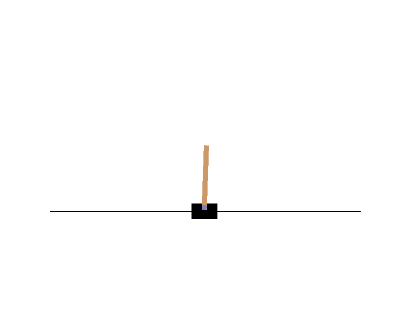

In [7]:
plt.figure(figsize=(5,4))
plt.imshow(img)
plt.axis("off")
plt.show()

Once you have finished playing with an environment, you should close it to free up resources:

In [8]:
env.close()

Now let's try MsPacman! This requires the [Atari dependencies](https://github.com/openai/gym#atari).

    pip install --upgrade "gym[atari]"

In [9]:
env = gym.make('MsPacman-v0')


INFO:gym.envs.registration:Making new env: MsPacman-v0
[2016-10-08 22:13:41,687] Making new env: MsPacman-v0


In [10]:
obs = env.reset()

Note that the observation is now a 3D numpy array of shape [width, height, channels] representing an image:

In [11]:
type(obs)

numpy.ndarray

In [12]:
obs.shape

(210, 160, 3)

The following command renders the environment to a Numpy array. Luckily, the Atari environments do not open separate windows when you use the `"rgb_array"` mode. :)

In [13]:
img = env.render(mode="rgb_array")

In this case, the rendering is simply equal to the observation:

In [14]:
(img == obs).all()

True

Now let's plot it. Welcome back to the 1980s!

<IPython.core.display.Javascript object>


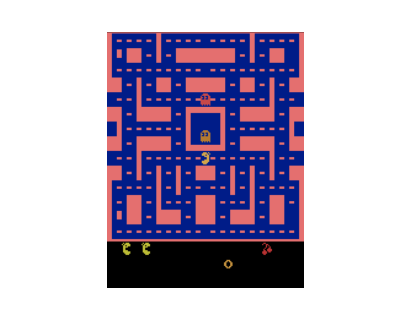

In [15]:
fig = plt.figure(figsize=(5,4))
plt.imshow(img)
plt.axis("off")
plt.show()

Let's create a little helper function to plot an environment:

In [16]:
def plot_environment(env, figsize=(5,4)):
    plt.figure(figsize=figsize)
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.axis("off")
    plt.show()

Let's see how to interact with an environment. Your agent will need to select an action from an "action space" (the set of possible actions). Let's see what this environment's action space looks like:

In [17]:
env.action_space

Discrete(9)

`Discrete(9)` means that the possible actions are integers 0 through 8, which represents the 9 possible positions of the joystick (0=center, 1=up, 2=right, 3=left, 4=down, 5=upper-right, 6=upper-left, 7=lower-right, 8=lower-left).

Next we need to tell the environment which action to play, and it will compute the next step of the game. Let's go left for 110 steps, then lower left for 40 steps:

In [18]:
env.reset()
for step in range(110):
    env.step(3) #left
for step in range(40):
    env.step(8) #lower-left

Where are we now?

<IPython.core.display.Javascript object>


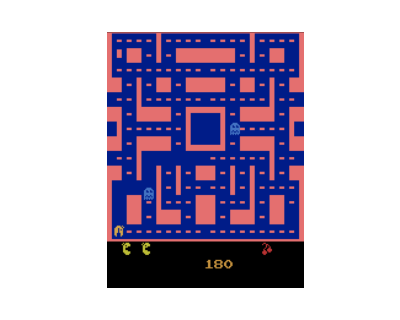

In [19]:
plot_environment(env)

The `step()` function actually returns several important objects:

In [20]:
obs, reward, done, info = env.step(0)

The observation tells the agent what the environment looks like, as discussed earlier. This is a 210x160 RGB image:

In [21]:
obs.shape

(210, 160, 3)

The environment also tells the agent how much reward it got during the last step:

In [22]:
reward

0.0

When the game is over, the environment returns `done=True`:

In [23]:
done

False

Finally, `info` is an environment-specific dictionary that can provide some extra information about the internal state of the environment. This is useful for debugging, but your agent should not use this information for learning (it would be cheating).

In [24]:
info

{}

Let's play one full game (with 3 lives), by moving in random directions for 10 steps at a time, recording each frame:

In [25]:
frames = []

n_max_iterations = 1000
n_change_steps = 10

obs = env.reset()
for iteration in range(n_max_iterations):
    img = env.render(mode="rgb_array")
    frames.append(img)
    if iteration % n_change_steps == 0:
        action = env.action_space.sample() # play randomly
    obs, reward, done, info = env.step(action)
    if done:
        break

Now show the animation (it's a bit jittery within Jupyter):

In [26]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=50):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    return animation.FuncAnimation(fig, update_scene, fargs=(frames, patch), frames=len(frames), repeat=repeat, interval=interval)

<IPython.core.display.Javascript object>


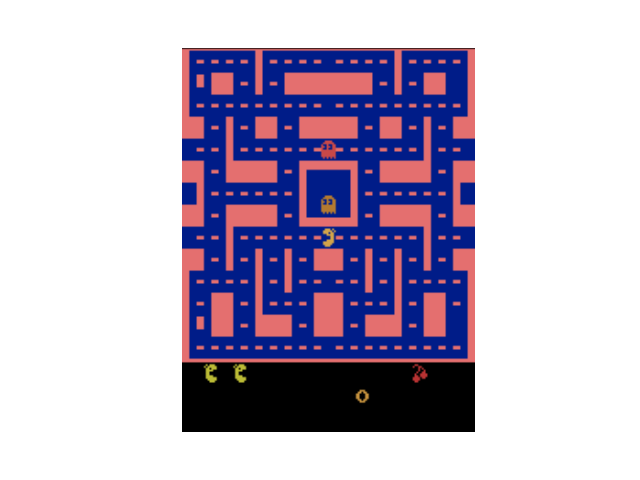

In [27]:
video = plot_animation(frames)
plt.show()

Ok, let's go back to the CartPole environment, it is much simpler to start with. But don't forget to close the MsPacman environment first:

In [28]:
env.close()

# A simple hard-coded policy

Let's create and initialize the CartPole environment again:

In [29]:
env = gym.make("CartPole-v0")

INFO:gym.envs.registration:Making new env: CartPole-v0
[2016-10-08 22:13:43,701] Making new env: CartPole-v0


In [30]:
obs = env.reset()

Now let's look at the action space:

In [31]:
env.action_space

Discrete(2)

Yep, just two possible actions: accelerate towards the left or towards the right. Let's push the cart left until the pole falls:

In [32]:
while True:
    obs, reward, done, info = env.step(0)
    if done:
        break

<IPython.core.display.Javascript object>


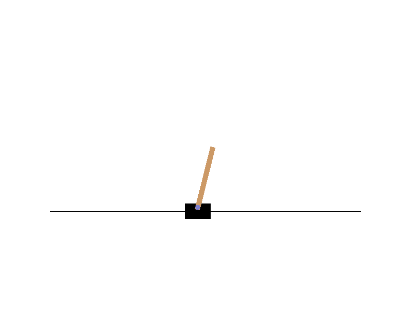

In [33]:
plot_environment(env)

Notice that the game is over when the pole tilts too much, not when it actually falls. Now let's reset the environment and push the cart to right instead:

In [34]:
env.reset()

while True:
    obs, reward, done, info = env.step(1)
    if done:
        break

<IPython.core.display.Javascript object>


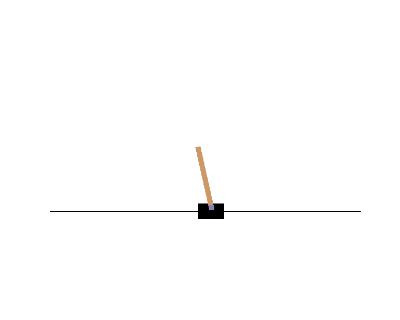

In [35]:
plot_environment(env)

Looks like it's doing what we're telling it to do. Now how can we make the poll remain upright? We will need to define a _policy_ for that. This is the strategy that the agent will use to select an action at each step. It can use all the past actions and observations to decide what to do.

Let's hard code a simple strategy: if the pole is tilting to the left, then push the cart to the left, and _vice versa_. Let's see if that works:

In [36]:
frames = []

n_max_iterations = 1000
n_change_steps = 10

obs = env.reset()
for iteration in range(n_max_iterations):
    img = env.render(mode="rgb_array")
    frames.append(img)
    
    # hard-coded policy
    position, velocity, angle, angular_velocity = obs
    if angle < 0:
        action = 0
    else:
        action = 1

    obs, reward, done, info = env.step(action)
    if done:
        break

<IPython.core.display.Javascript object>


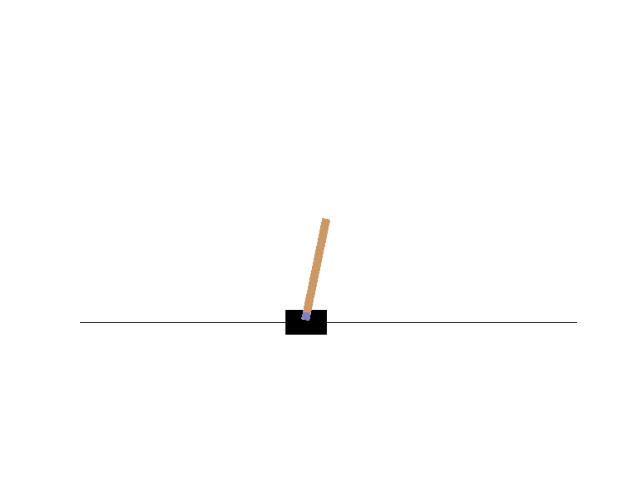

In [37]:
video = plot_animation(frames)
plt.show()

Nope, the system is unstable and after just a few wobbles, the pole ends up too tilted: game over. We will need to be smarter than that!

# Policy Gradients

Let's create a neural network that will take the observations as inputs, and output the action to take. More precisely, it will output a probability for each action, and we will sample an action based on those probabilities. For example, if it says that the probability of pushing left should be 70%, and the probability of pushing right should be 30%, then we will pick a random number between 0 and 1 and if it is lower than 0.7 we will push left, or else we will push right. This approach lets the agent find the right balance between exploring new actions and exploiting the actions that are known to work well. Suppose you go to the same restaurant every week, and the first time you really enjoyed the caesar salad, you could order the same thing every week and be guaranteed to enjoy your meal. But you may be missing out on another great dish. Once in a while, you should try out something new.

In [38]:
import tensorflow as tf

from tensorflow.contrib.layers import fully_connected

n_inputs = 4
n_hidden = 4
n_outputs = 1

learning_rate=0.01

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
y = tf.placeholder(tf.float32, shape=[None, n_outputs])
hidden = fully_connected(X, n_hidden, activation_fn=tf.nn.elu)
logits = fully_connected(hidden, n_outputs, activation_fn=None)
outputs = tf.nn.softmax(logits)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, y)
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(cross_entropy)

Now to train this network we will need to feed the input batches `X` and the targets `y`. The inputs are easy enough, these will be the observations.

_Note_: in this particular environment, the past actions and observations can safely be ignored, since you can observe the environment's full state. If there were some hidden state then you may need to consider all past actions and observations in order to try to infer the hidden state of the environment. For example, if the environment only revealed the position of the cart but not its velocity, you would have to consider not only the current observation but also the previous observation in order to estimate the current velocity. Another example is if the observations are noisy: you may want to use the past few observations to estimate the most likely current state. Our problem is thus as simple as can be: the current observation is noise-free and contains the environment's full state.

But what about the labels? How can we tell what the target probabilities should be? One option is to let this policy network play the game say 100 times. Then rank the games according to the total reward they get. The actions taken during the best games were good, on average, so they should be made a bit more likely, while the actions taken during the worst games were bad, on average, so they should be made less likely. Of course, perhaps the policy network made a few good moves during a very bad game, and unfortunately these good moves will be made less likely, but that's ok because if we repeat the process many times, after a while the good moves should on average get more and more likely, and the bad moves should get less and less likely. A good basketball player sometimes plays in a really bad team: this obviously damages his reputation, but if he stars in a sufficient number of movies, overall his reputation should correspond to his talent.

In [39]:
obs = env.reset()
while True:
    obs, reward, done, info = env.step(env.action_space.sample())
    print(reward)
    if done:
        break

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


**Work in progress – more content coming soon...**

# Exercise solutions

Coming soon...